<a href="https://colab.research.google.com/github/sohamjain91/Financial-Data-Predictor-/blob/main/GDP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
pip install tvdatafeed


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.1 MB/s 


In [5]:
import numpy as np
import pandas as pd
#import yfinance as yf
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt                                                                          #Loading important libraries 
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 12
from tvDatafeed import TvDatafeed, Interval
tv = TvDatafeed('aotleviackerman317','Sm$ge.L#e9FP5uF')

In [90]:
ticker = ['ECONOMICS:INGDPPCP']
lag = input('Value of Lags = ') # Only 1 or 2, But use 1 = Value of D                                       #Giving Values
Forecast_Years = int(input('Value of Years = '))


Value of Lags = 1
Value of Years = 200


In [91]:
Names = []
for i in range(len(ticker)):
  Names.append('th{name}'.format(name = i))
gh = pd.DataFrame()
Data = []
for i in range(len(ticker)):                                                                                #importing data using TradingView library 
  th = tv.get_hist(symbol= ticker[i], n_bars = 10000000000)
  gh[ticker[i]] = th['close']
  Data.append(gh)
df = Data[0]

In [92]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(ts):

  TR = []  

  for i in range(len(ticker)):
    hm = ts.iloc[:,i].to_frame()

    #Determining rolling statistics

    MovingAverage = hm.rolling(window = 5).mean()
    MovingSTD = hm.rolling(window = 5).std()

    #Plot rolling statistics
   
    plt.figure(figsize = (4,3))
    plt.title('Rolling mean and STD')
    plt.plot(hm, color= 'blue', label = 'Price')
    plt.plot(MovingAverage, color= 'red', label = 'MA')                                                                             #Adfuller test code
    plt.plot(MovingSTD, color= 'black', label = 'STD')
    plt.legend(loc = 'best')
    plt.grid()
    plt.show()

    #Perform Dickey fuller test

    print('Results of dickey fuller test {name}'.format(name = ticker[i]))
    dftest = adfuller(hm, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistics', 'P Value', 'Lags Used', 'Number of observations used'])

    for key,value in dftest[4].items():
      dfoutput['Critical Value (%s)'%key] = value

    TR.append(dfoutput)

  TR = pd.DataFrame(TR, index = ticker)
  print(TR)

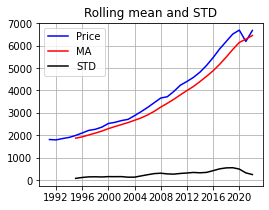

Results of dickey fuller test ECONOMICS:INGDPPCP
                    Test Statistics  P Value  Lags Used  \
ECONOMICS:INGDPPCP         1.498749  0.99752        0.0   

                    Number of observations used  Critical Value (1%)  \
ECONOMICS:INGDPPCP                         31.0            -3.661429   

                    Critical Value (5%)  Critical Value (10%)  
ECONOMICS:INGDPPCP            -2.960525             -2.619319  


In [93]:
test_stationarity(df)

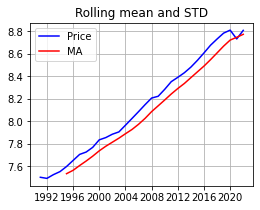

In [94]:
dflogscale = []
for i in range(len(ticker)):

  hf = df.iloc[:,i]
  
  df_logscale = np.log(hf)
  movingaveragelog = df_logscale.rolling(window = 5).mean()
  dflogscale.append(df_logscale)
                                                                                                 #Checking stationarity of the log graph
  plt.figure(figsize = (4,3))
  plt.title('Rolling mean and STD')
  plt.plot(df_logscale, color= 'blue', label = 'Price')
  plt.plot(movingaveragelog, color= 'red', label = 'MA')
  plt.legend(loc = 'best')
  plt.grid()
  plt.show()

In [95]:
dflogscale = pd.DataFrame(dflogscale)
dflogscale = dflogscale.transpose()


In [96]:
df_logdiffshift = dflogscale - dflogscale.shift()
df_logdiffshift.dropna(inplace = True)

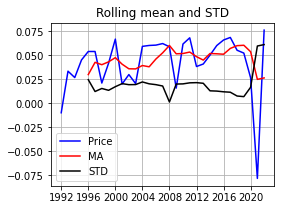

Results of dickey fuller test ECONOMICS:INGDPPCP
                    Test Statistics   P Value  Lags Used  \
ECONOMICS:INGDPPCP        -5.416422  0.000003        0.0   

                    Number of observations used  Critical Value (1%)  \
ECONOMICS:INGDPPCP                         30.0             -3.66992   

                    Critical Value (5%)  Critical Value (10%)  
ECONOMICS:INGDPPCP            -2.964071             -2.621171  


In [97]:
test_stationarity(df_logdiffshift)                                                                   #Checking stationarity with lag = 1, Now the data is stationary 

In [98]:
df_logdiffshift2 = df_logdiffshift - df_logdiffshift.shift()
df_logdiffshift2.dropna(inplace = True)

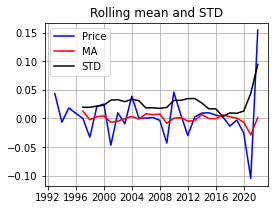

Results of dickey fuller test ECONOMICS:INGDPPCP
                    Test Statistics       P Value  Lags Used  \
ECONOMICS:INGDPPCP        -7.433387  6.274680e-11        0.0   

                    Number of observations used  Critical Value (1%)  \
ECONOMICS:INGDPPCP                         29.0             -3.67906   

                    Critical Value (5%)  Critical Value (10%)  
ECONOMICS:INGDPPCP            -2.967882             -2.623158  


In [99]:
test_stationarity(df_logdiffshift2)                                                                  #Checking stationarity with lag = 2

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:671: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning,


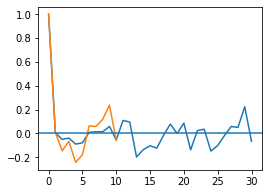

In [100]:
#ACF and PACF PLOT
ACF = []
PACF = []

for i in range(len(ticker)):

  from statsmodels.tsa.stattools import acf , pacf

  lag_acf = acf(df_logdiffshift.iloc[:, i], nlags=30)
  lag_pacf = pacf(df_logdiffshift.iloc[:, i], nlags=10, method = 'ols')

  ACF.append(lag_acf)
  PACF.append(lag_pacf)

  plt.figure(figsize = (4,3))
  plt.plot(lag_acf)
  plt.plot(lag_pacf)
  plt.axhline(y=0)

In [101]:
AP = pd.DataFrame(ACF)
AP = AP.transpose()
PP = pd.DataFrame(PACF)
PP = PP.transpose()

In [102]:
#Finding P and Q value
Final_ACF = []
for z in range(len(ticker)):
  ER = AP.iloc[:,z].to_list()
  for i in ER:
    if i<0:
      Final_ACF.append(ER.index(i))
      break
Final_PACF = []
for z in range(len(ticker)):
  EN = PP.iloc[:,z].to_list()
  for i in EN:
    if i<0:
      Final_PACF.append(EN.index(i))
      break

In [103]:
Final_ACF

[2]

In [104]:
Final_PACF

[2]

In [129]:
from statsmodels.tsa.arima_model import ARIMA

hsd = []

for i in range(len(ticker)):

  p = int(Final_ACF[i])
  q = int(Final_PACF[i])
  d = int(lag)

  isd = dflogscale.iloc[:,i].to_frame()

  model = ARIMA(isd, order = (p, d, q))
  results_AR = model.fit(transparams=False)                              #Fitting the model

  e = int(Forecast_Years)

  tf = results_AR.forecast(e)
  tf = np.exp(tf[0])
  hsd.append(tf)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


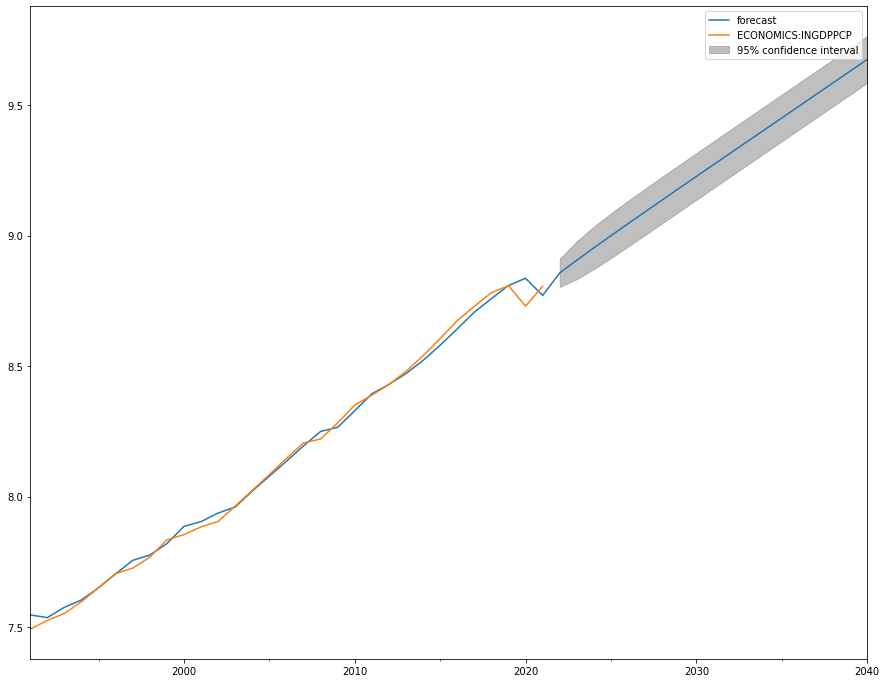

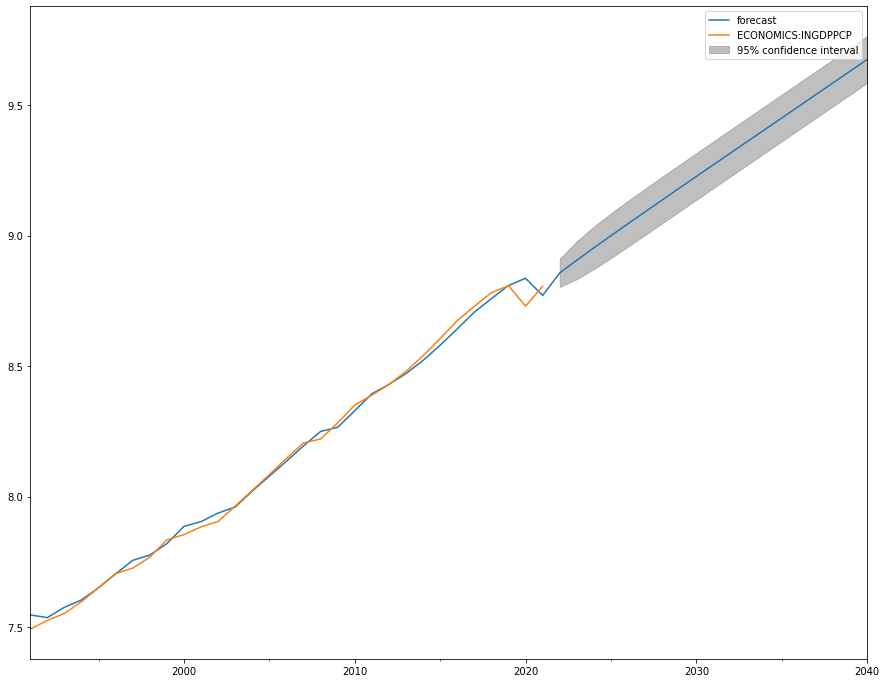

In [158]:
results_AR.plot_predict(end = 50)

In [150]:
print(results_AR.summary())


                              ARIMA Model Results                               
Dep. Variable:     D.ECONOMICS:INGDPPCP   No. Observations:                   31
Model:                   ARIMA(2, 1, 2)   Log Likelihood                  66.367
Method:                         css-mle   S.D. of innovations              0.028
Date:                  Wed, 12 Oct 2022   AIC                           -120.733
Time:                          16:19:35   BIC                           -112.129
Sample:                      12-31-1991   HQIC                          -117.929
                           - 12-31-2021                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          0.0447      0.002     19.465      0.000       0.040       0.049
ar.L1.D.ECONOMICS:INGDPPCP     1.0171      2.106      0.483      0.

In [151]:
Year = []

for i in range(2022, 2022+Forecast_Years, 1):
  Year.append(i)

In [152]:
hsd = pd.DataFrame(hsd)
hsd = hsd.transpose()
Final_Prediction = hsd

In [154]:
Final_Prediction['Years'] = Year
SG= Final_Prediction.set_index('Years')

ValueError: ignored

In [155]:
SG.columns = ticker
SG

,ECONOMICS:INGDPPCP
Years,
2022,7.026591e+03
2023,7.377676e+03
2024,7.735405e+03
2025,8.103483e+03
2026,8.484320e+03
...,...
2217,4.366556e+07
2218,4.566306e+07
2219,4.775195e+07


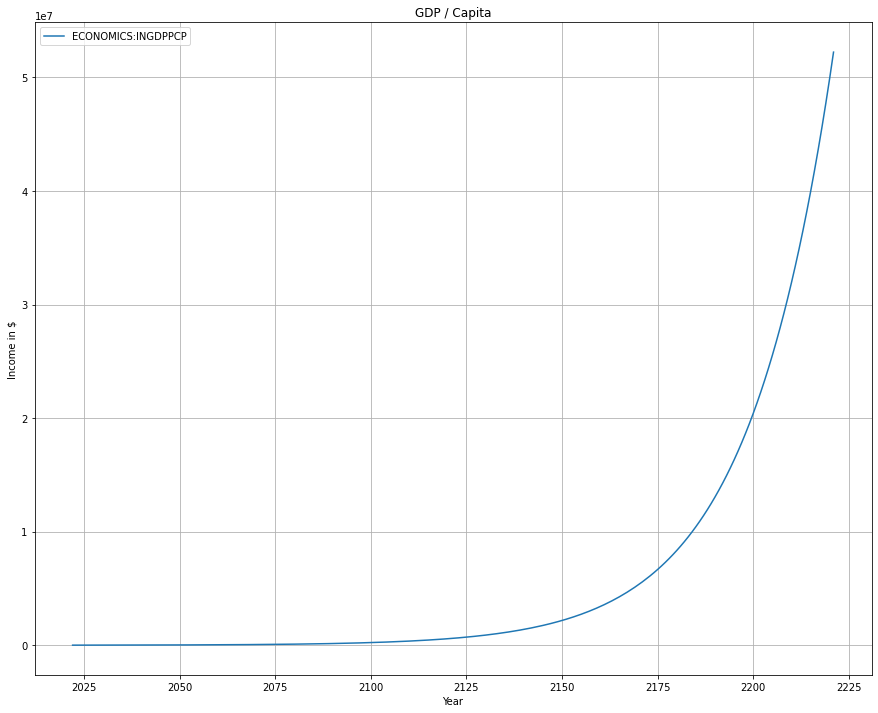

In [156]:
SG.plot(label = 'ticker')
plt.title('GDP / Capita')
plt.xlabel('Year')
plt.ylabel('Income in $')                                                               #Plotting Projections
plt.legend(loc= 'upper left')
plt.grid(True)
plt.show()